# Poisson Thompson Sampling

In [1]:
import numpy as np

from scipy.stats import gamma

import pylab as plt

### Parametros de ajuste y medias de tres productos

Parametros obtenidos de una regresion de Poisson con los datos actuales

In [2]:
PRODUCTS = {'surrogate': {'alpha': -0.02473518, 'beta': 5.47213038, 'mean': 28.8},
            'extracash': {'alpha': -0.05629794, 'beta': 5.64341742, 'mean': 21.85},
            'plussurrogate': {'alpha': -0.22629794, 'beta': 5.64341742, 'mean': 6.4},
            'test': {'alpha': -7., 'beta': 50., 'mean': 28.8}
            }

### Muestreo de la demanda real

In [3]:
PROD = 'surrogate'

In [19]:
def sample_demand(price: float) -> int:
    """
    Esta funcion realiza el muestreo de la distribucion de Poisson 
    con una media igual a la evaluacion de la curva de demanda ajustada previamente.
    
    Este sampleo reemplaza a la obtencion de datos en directo.
    Este metodo puede ser usado como simulador, usando esta funcion,
    o como optimizador en directo introduciendo la demanda actual.
    
    Args:
    price: float, precio ofrecido del producto
    
    Return:
    demand sample: int, demanda estimada para ese precio
    
    PUEDO SALTARME ESTE PASO, EVALUANDO LA FUNCION DE AJUSTE**, AUNQUE INTRODUZCO RANDOMNESS
    
    np.poisson.random -> https://numpy.org/doc/stable/reference/random/generated/numpy.random.poisson.html
    """
    
    global PROD
    
    prod = PRODUCTS[PROD]
    
    demand = np.exp(prod['alpha']*price + prod['beta'])*100
    #demand = prod['alpha']*price + prod['beta']
    
    return np.random.poisson(demand, 1)[0]

In [20]:
sample_demand(0.1)  

23710

In [6]:
# **EVALUACION DE LA FUNCION DE AJUSTE

prod = PRODUCTS[PROD]

np.exp(prod['alpha']*0.1*100 + prod['beta'])*100

18582.00217013308

### Muestreo del modelo Gamma-Poisson

* Parametros iniciales de las distribuciones Gamma
* Sampleo desde el modelo Gamma-Poisson

In [7]:
# initial params

alpha_0 = 300.     
beta_0 = 1.

PRICES = np.arange(0.1, 1., 0.1)
#PRICES = np.arange(2.49, 5.99, 1)

PRICES = np.round(PRICES, 1)

PARAMS = [{'price': p, 'alpha': alpha_0, 'beta': beta_0} for p in PRICES]

PARAMS

[{'price': 0.1, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.2, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.3, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.4, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.5, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.6, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.7, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.8, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.9, 'alpha': 300.0, 'beta': 1.0}]

In [8]:
def sample_demand_from_model(parameters: list) -> list:
    """
    Muestreo del modelo Gamma-Poisson:
    
    Args:
    parameters: list, lista de diccionarios con los parametros de las gammas de cada precio
    
    Return:
    list, lista de parametros actualizados para cada precio
    """
    return list(map(lambda v: np.random.gamma(v['alpha'], 1/v['beta']), parameters))

### Obtencion del precio optimo (precio ofrecido)

In [9]:
def get_optimal_price(prices: list, demands: list) -> dict:
    """
    Identifica el precio optimo. 
    Nota: este es el modelo Greedy, siempre el argmax.
    Funcion a ser modelada para diferentes algoritmos.
    """
    
    index = np.argmax(prices * demands)
    
    return {'price_index': index, 'price': prices[index]}

### Viz

In [10]:
def plot_(parameters: list, iteration: int):
    
    x = np.arange(0, 10, 0.20)
    
    for dist in parameters:
        
        y = gamma.pdf(x, a=dist["alpha"], scale= 1/dist["beta"])
        plt.plot(x, y, label = dist["price"])
        plt.xlabel("demand")
        plt.ylabel("pdf")
        
    plt.title(f"PDFs after Iteration: {iteration}")
    plt.legend(loc="upper right")
    plt.show();

## Simulacion

In [11]:
price_counts = {p: 0 for p in PRICES}

price_counts

{0.1: 0, 0.2: 0, 0.3: 0, 0.4: 0, 0.5: 0, 0.6: 0, 0.7: 0, 0.8: 0, 0.9: 0}

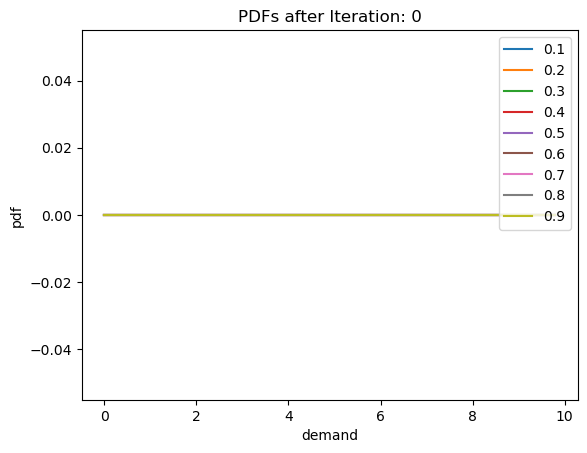

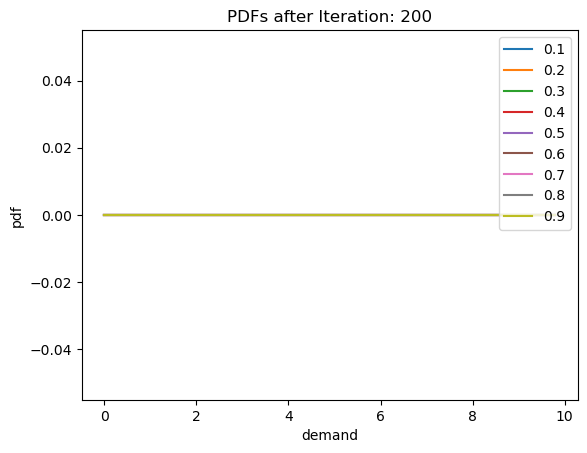

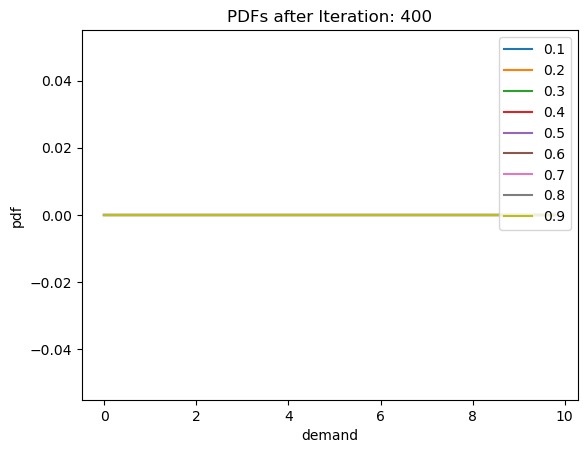

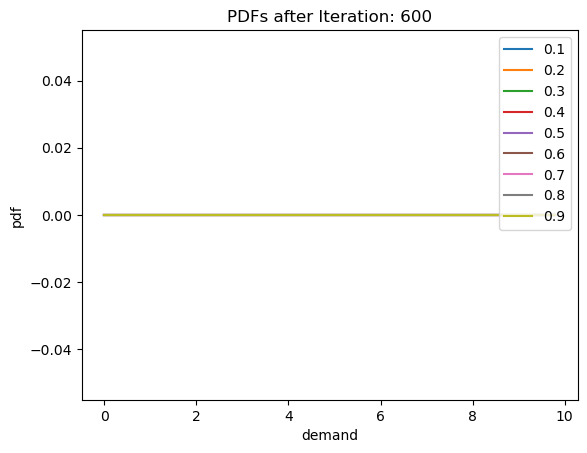

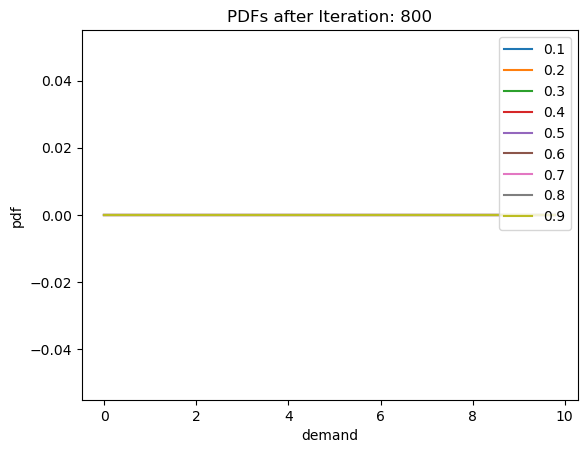

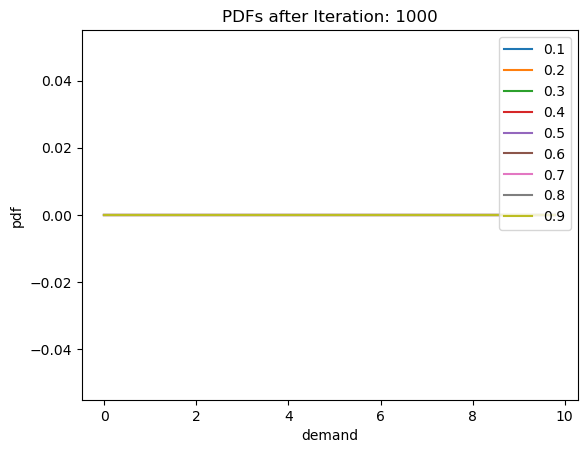

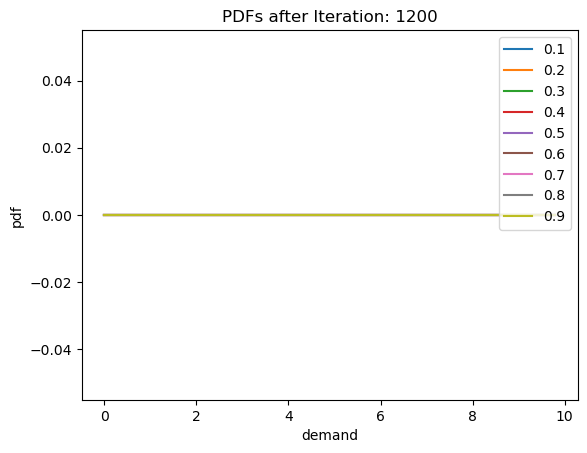

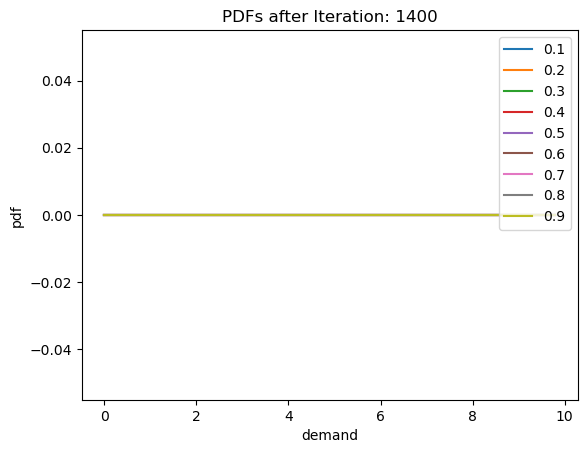

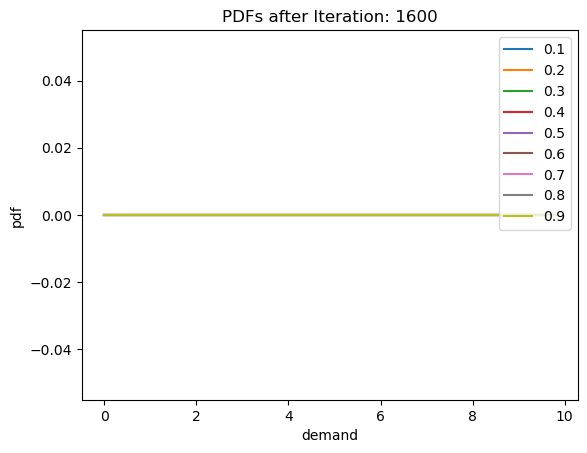

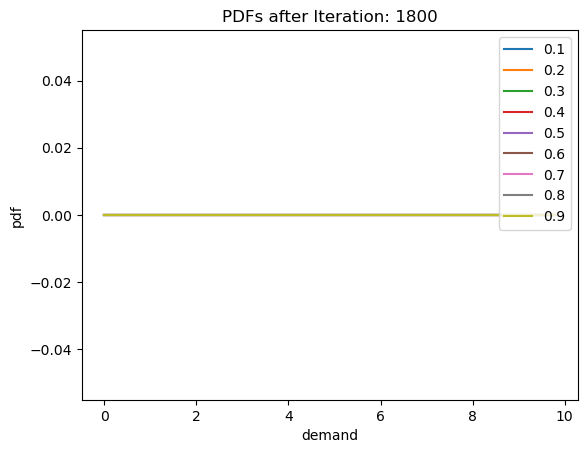

In [12]:
# para N clientes

N = 2000

for t in range(N):

    # muestreo de demanda desde el modelo gamma-poisson
    demands = sample_demand_from_model(PARAMS)

    # obtener precio optimo
    optimal_price_res = get_optimal_price(PRICES, demands)

    # incrementar la cuenta de ese precio
    price_counts[optimal_price_res['price']] += 1

    # ofrecer precio optimo y OBSERVAR demanda
    true_demand = sample_demand(optimal_price_res['price'])

    # actualizar parametros del modelo / actualizar creencia
    v = PARAMS[optimal_price_res['price_index']] # para ese precio...
    v['alpha'] += true_demand                     # alfa + demanda
    v['beta'] += 1                               # beta + 1
    
    
    if t%200 == 0:
        plot_(PARAMS, t)

In [13]:
price_counts

{0.1: 0, 0.2: 0, 0.3: 0, 0.4: 0, 0.5: 0, 0.6: 0, 0.7: 0, 0.8: 0, 0.9: 2000}

In [14]:
PARAMS

[{'price': 0.1, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.2, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.3, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.4, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.5, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.6, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.7, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.8, 'alpha': 300.0, 'beta': 1.0},
 {'price': 0.9, 'alpha': 5135971.0, 'beta': 2001.0}]

In [15]:
demands

[261.4540136854013,
 301.2413193027977,
 302.6097301282575,
 285.4074648204034,
 330.3954001460562,
 308.62567090491416,
 299.52335707721164,
 314.57006900876576,
 2566.3301475247113]

In [16]:
optimal_price_res

{'price_index': 8, 'price': 0.9}

In [17]:
true_demand

2589

In [18]:
v

{'price': 0.9, 'alpha': 5135971.0, 'beta': 2001.0}